# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('../../../GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 360

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer10']]

In [6]:
data

,customer10
0,266.666667
1,277.419355
2,249.462366
3,226.881720
4,208.602151
...,...
8756,325.806452
8757,280.645161
8758,289.247312
8759,290.322581


<AxesSubplot: >

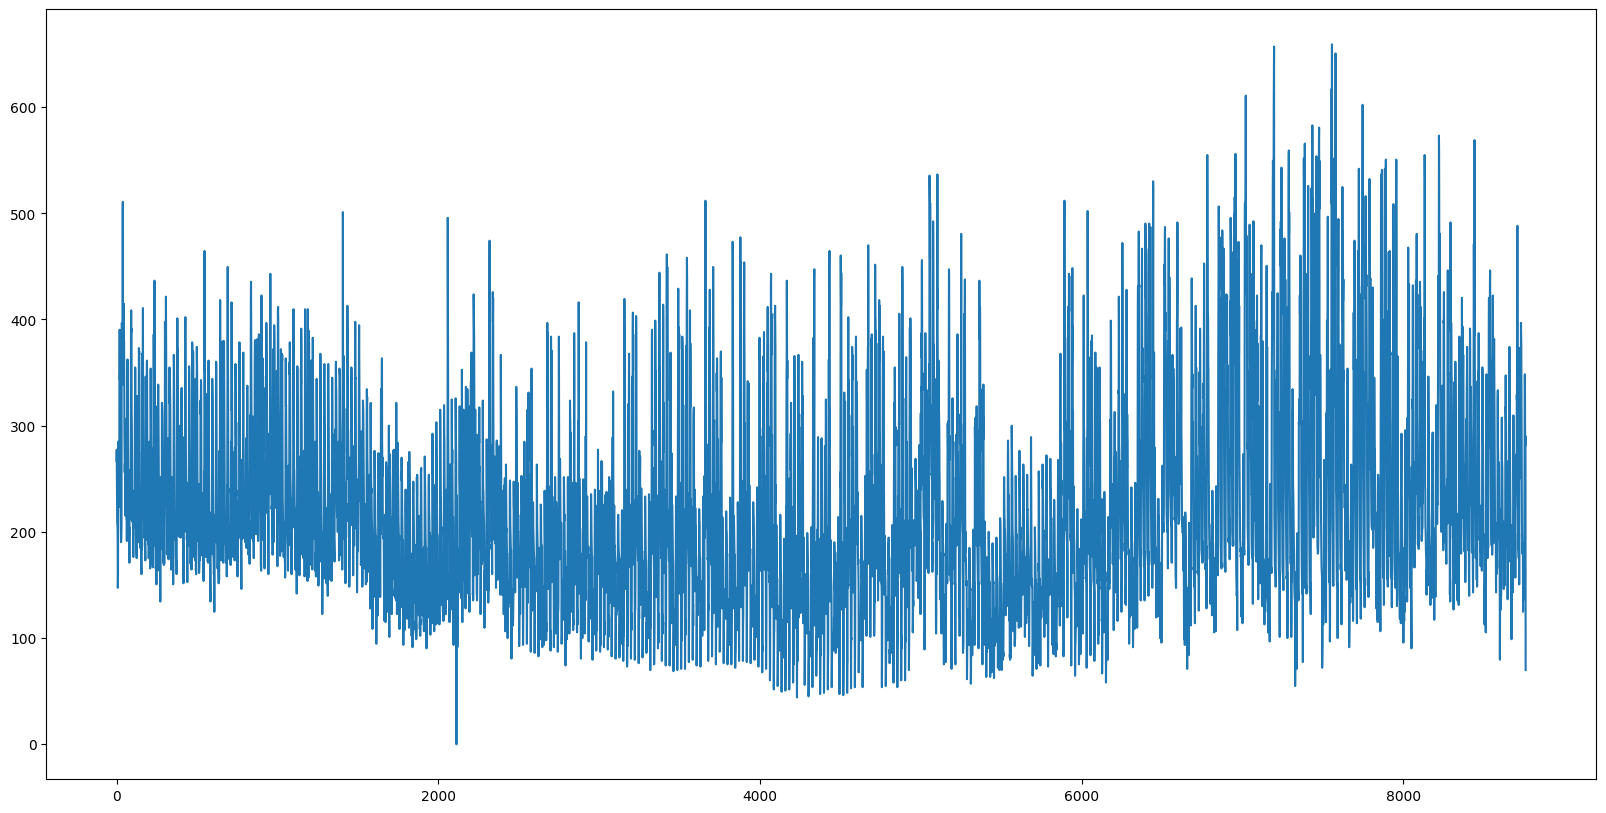

In [7]:
plt.figure(figsize=(20,10))
data['customer10'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360 # 1440
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer10
0,266.666667
1,277.419355
2,249.462366
3,226.881720
4,208.602151
...,...
8756,325.806452
8757,280.645161
8758,289.247312
8759,290.322581


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_853507/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [17]:
train.tail(11)

,customer10
6830,120.430108
6831,130.107527
6832,107.526882
6833,108.602151
6834,106.451613
6835,167.741935
6836,243.010753
6837,236.559140
6838,213.978495
6839,186.021505


In [18]:
y_train.size()

torch.Size([5762, 360])

In [19]:
y_train[-1,-10:]

tensor([130.1075, 107.5269, 108.6021, 106.4516, 167.7419, 243.0108, 236.5591,
        213.9785, 186.0215, 179.5699], device='cuda:0')

In [20]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [21]:
x_train.size()

torch.Size([5762, 720])

In [22]:
x_val.size()

torch.Size([673, 720])

In [23]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [25]:
import copy

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 880298.726
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 792983.263
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 781582.868
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 729489.962
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 67

## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [27]:
output = outputs
label = labels

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

6659.925

In [30]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

6659.925

### validation set에 대해서 attribution 구하기

In [31]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [32]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [33]:
print(temp.size()) # sum하기전에 형태

torch.Size([720])


In [34]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

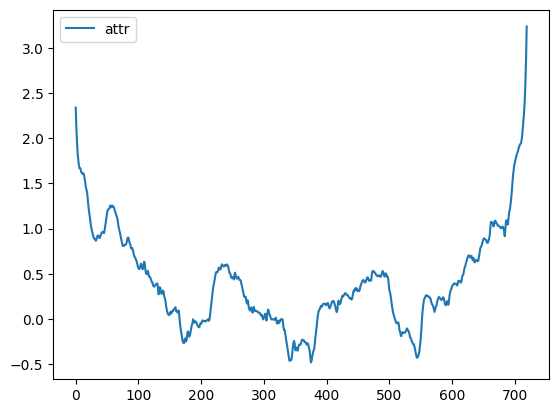

In [35]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

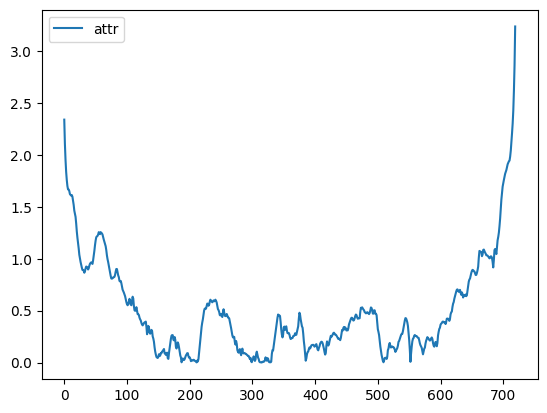

In [36]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [37]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
17,1.433095
18,1.403466
19,1.338981
20,1.260960
21,1.200823
...,...
691,1.178290
692,1.209867
693,1.251482
694,1.313043


In [38]:
outlier_max

attr    1.446299
dtype: float64

In [39]:
outlier_min

attr   -0.611505
dtype: float64

<AxesSubplot: >

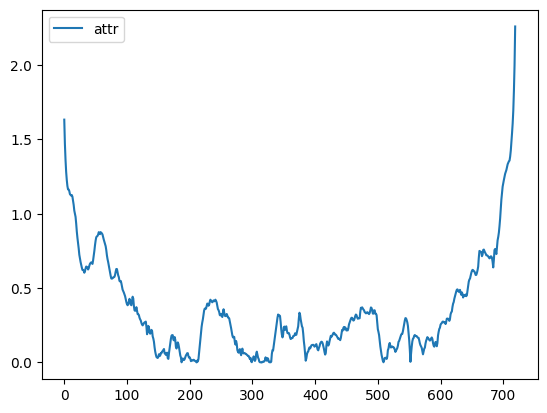

In [40]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [41]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.349569
std,0.337142
min,0.000000
25%,0.111205
50%,0.251424
75%,0.470411
max,2.259015


## 0과 1사이의 분포 확인하기

In [42]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
17,1.000000
18,0.979312
19,0.934287
20,0.879810
21,0.837821
...,...
691,0.822087
692,0.844135
693,0.873193
694,0.916176


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

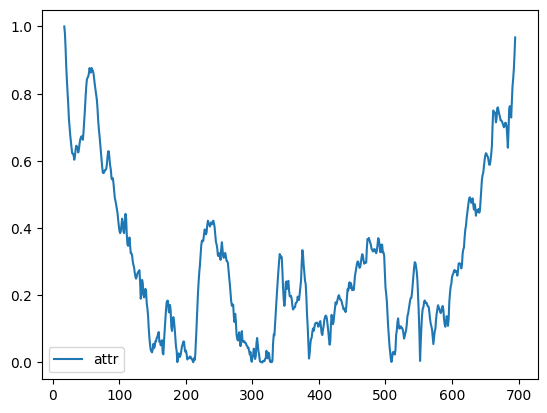

In [43]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

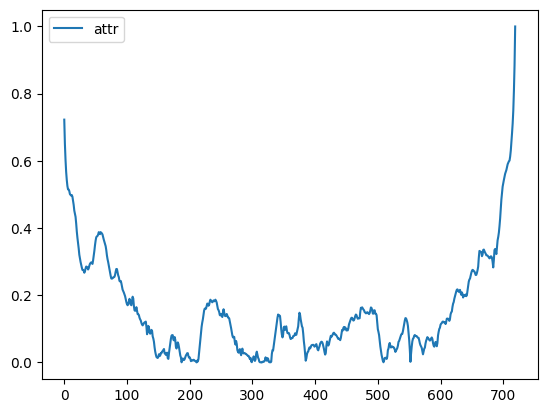

In [44]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [45]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [46]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


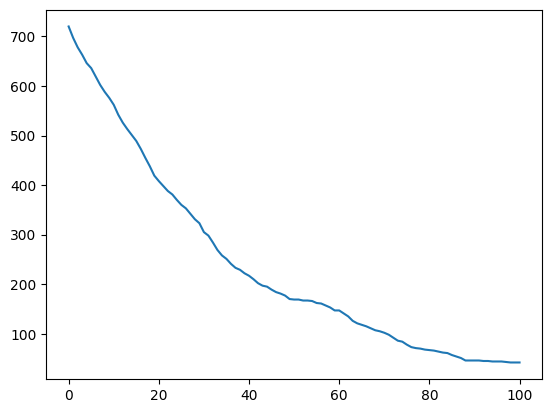

In [47]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [48]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:629570.22155091
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:654089.2677390969
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
19번째 모델 Training 완료 마지막 Epoch loss:663882.314828726
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
28번째 모델 Training 완료 마지막 Epoch loss:679355.2710229224
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
29번째 모델 Training 완료 마지막 Epoch loss:678867.9676768543
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 Epoch loss:715201.3368711367
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:710207.3279747596
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
58번째 모델 Training 완료 마지막 Epoch loss:709535.6837010646
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:708890.7266805461
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
68번째 모델 Training 완료 마지막 Epoch loss:708636.343417324

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:719300.5365728022
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
78번째 모델 Training 완료 마지막 Epoch loss:720141.4070548592
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
89번째 모델 Training 완료 마지막 Epoch loss:724117.9424579327
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
99번째 모델 Training 완료 마지막 Epoch loss:724708.3217075893
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
100번째 모델 Training 완료 마지막 Epoch loss:724708.3217075893
changed


In [49]:
val_y # 다음 예측 타겟값

tensor([[195.6989, 293.5484, 291.3979,  ..., 358.0645, 248.3871, 189.2473],
        [293.5484, 291.3979, 319.3548,  ..., 248.3871, 189.2473, 216.1290],
        [291.3979, 319.3548, 284.9462,  ..., 189.2473, 216.1290, 290.3226],
        ...,
        [291.3979, 250.5376, 222.5806,  ..., 278.4946, 273.1183, 243.0108],
        [250.5376, 222.5806, 205.3763,  ..., 273.1183, 243.0108, 234.4086],
        [222.5806, 205.3763, 201.0753,  ..., 243.0108, 234.4086, 240.8602]],
       device='cuda:0')

In [50]:
val_x # 예측 하는 값

tensor([[251.6129, 310.7527, 366.6667,  ..., 144.0860, 138.7097, 141.9355],
        [310.7527, 366.6667, 338.7097,  ..., 138.7097, 141.9355, 195.6989],
        [366.6667, 338.7097, 305.3763,  ..., 141.9355, 195.6989, 293.5484],
        ...,
        [197.8495, 173.1183, 155.9140,  ..., 408.6021, 337.6344, 319.3548],
        [173.1183, 155.9140, 147.3118,  ..., 337.6344, 319.3548, 291.3979],
        [155.9140, 147.3118, 140.8602,  ..., 319.3548, 291.3979, 250.5376]],
       device='cuda:0')

In [51]:
result/68

185.9064510569853

In [52]:
val_x.size()

torch.Size([33, 720])

            out
0  10022.882812


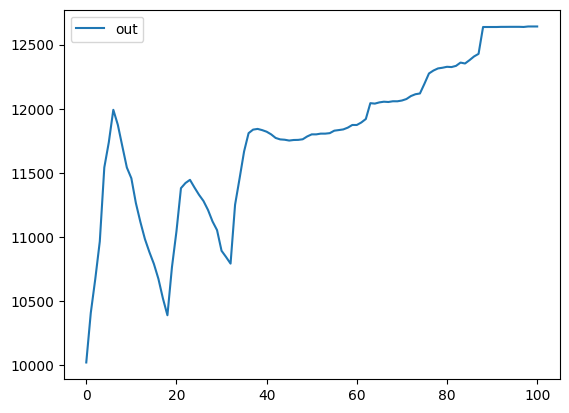

In [53]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [54]:
out_df 

,out
0,10022.882812
1,10408.881836
2,10674.299805
3,10966.465820
4,11542.569336
...,...
96,12638.933594
97,12637.853516
98,12641.638672
99,12641.638672


         out
0  76.071487


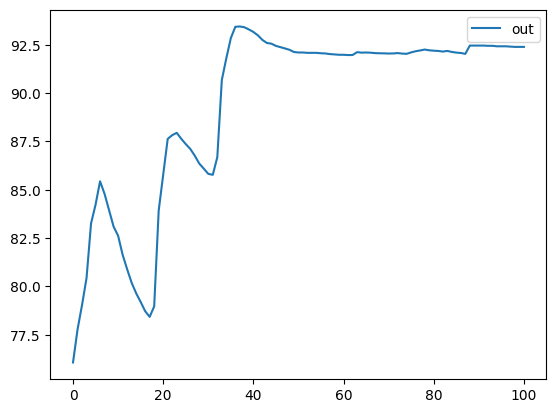

In [55]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [56]:
out_df 

,out
0,76.071487
1,77.773224
2,79.042229
3,80.438866
4,83.262260
...,...
96,92.417252
97,92.400726
98,92.386368
99,92.386368


         out
0  28.726989


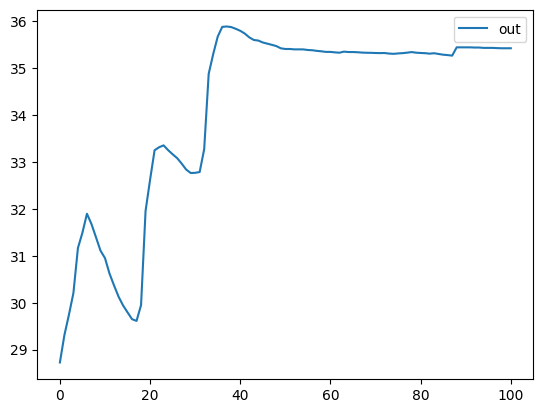

In [57]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [58]:
out_df 

,out
0,28.726989
1,29.310593
2,29.741144
3,30.208081
4,31.166437
...,...
96,35.429478
97,35.424665
98,35.421804
99,35.421804


          out
0  100.114349


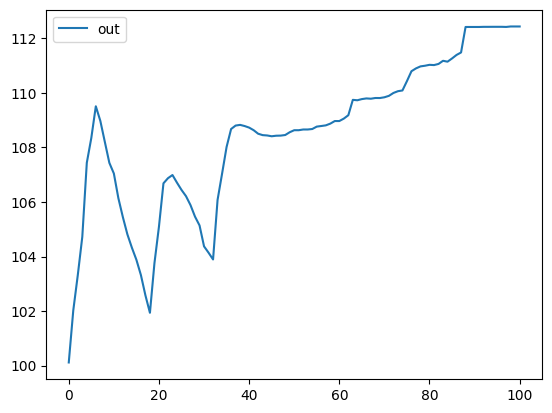

In [59]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [60]:
out_df 

,out
0,100.114349
1,102.023926
2,103.316505
3,104.720894
4,107.436348
...,...
96,112.423012
97,112.418205
98,112.435043
99,112.435043


In [61]:
attr_df.describe()

,attr
count,720.000000
mean,0.154744
std,0.149243
min,0.000000
25%,0.049227
50%,0.111298
75%,0.208237
max,1.000000
